https://www.kaggle.com/aithammadiabdellatif/keras-lux-ai-reinforcement-learning

In [1]:
!pip install kaggle-environments -U

In [2]:
!git clone https://github.com/Lux-AI-Challenge/Lux-Design-2021.git

fatal: destination path 'Lux-Design-2021' already exists and is not an empty directory.


In [3]:
!cp -r ./Lux-Design-2021/kits/python/simple/lux .

In [4]:
from kaggle_environments import make
from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES, Position
from lux.game_objects import Unit
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate

Loading environment football failed: No module named 'gfootball'


In [5]:
import math, sys
import numpy as np
import random
from collections import deque

import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_hub as hub

from IPython.display import clear_output

In [6]:
# 아무것도 안하는 빈 agent
def agent(observation, configuration):
    global game_state
    
    ### Do not edit ###
    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state._update(observation["updates"][2:])
        game_state.id = observation.player
#         print("new episode")
    else:
        game_state._update(observation["updates"])
    
    actions = []

    ### AI Code goes down here! ### 
    player = game_state.players[observation.player]
    opponent = game_state.players[(observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height
#     print(observation['reward'])

    return actions

In [7]:
env = make("lux_ai_2021", configuration={"seed": 562124210, "loglevel": 2}, debug=True)
steps = env.run([agent, agent])
# env.render(mode="ipython", width=1000, height=800)

<h1>The input of the model

In [8]:
def get_inputs(game_state):
    w, h = game_state.map.width, game_state.map.height

    # 맵에 resource가 얼마나 남아있는지 2차원 배열로 표현
    M = [[0 if game_state.map.map[j][i].resource == None else game_state.map.map[j][i].resource.amount for i in range(w)] for j in range(h)]
    M = np.array(M).reshape((h,w,1))

    # 자신의 유닛 피쳐 [유닛 타입, 쿨다운 시간, 나무, 석탄, 우라늄]
    U = [[[0,0,0,0,0] for i in range(w)] for j in range(h)]
    units = game_state.players[0].units
    for i in units:
        U[i.pos.y][i.pos.x] = [i.type, i.cooldown, i.cargo.wood, i.cargo.coal, i.cargo.uranium]
    U = np.array(U)

    # citytile 피쳐 [쿨다운, 연료, 연료 소모량, 팀]
    e = game_state.players[1].cities
    C = [[[0,0,0,0] for i in range(w)] for j in range(h)]
    for k in e:
        citytiles = e[k].citytiles
        for i in citytiles:
            C[i.pos.y][i.pos.x] = [i.cooldown, e[k].fuel, e[k].light_upkeep, e[k].team]
    C = np.array(C)

    # 모든 피쳐 하나로 union
    E = np.dstack([M,U,C])

    return E

In [9]:
input_shape = get_inputs(game_state).shape
input_shape

(32, 32, 10)

<h1>Model

In [10]:
def get_model(game_state):
    inputs = keras.Input(shape = get_inputs(game_state).shape, name = 'The game map')

    # 1*1 Conv를 3번 돌림 
    c = layers.Conv2D(8, (1,1), activation='relu')(inputs)
    c = layers.Conv2D(8, (1,1), activation='relu')(c)
    c = layers.Conv2D(8, (1,1), activation='relu')(c)

    outputs = layers.Dense(8, activation='softmax', name='direction')(c)

    model = keras.Model(inputs = inputs, outputs = outputs)
    model.compile(loss='mse', optimizer='adam')

    return model

In [11]:
model = get_model(game_state)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
The game map (InputLayer)    [(None, 32, 32, 10)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 8)         88        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         72        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         72        
_________________________________________________________________
direction (Dense)            (None, 32, 32, 8)         72        
Total params: 304
Trainable params: 304
Non-trainable params: 0
_________________________________________________________________


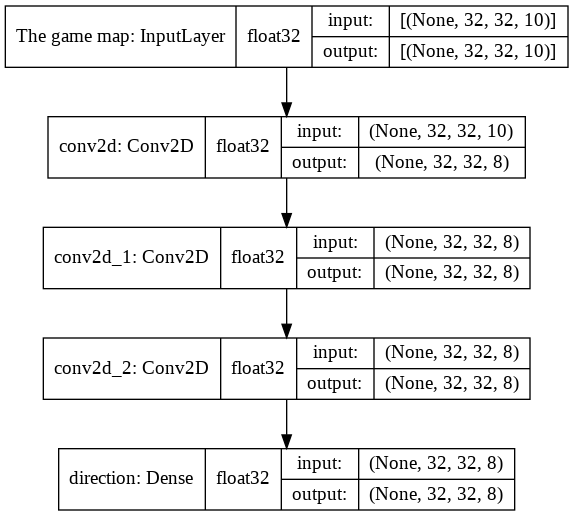

In [12]:
tf.keras.utils.plot_model(
    model,
    show_shapes=1,
    show_dtype=1,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

<h1>Predict actions

In [13]:
x = get_inputs(game_state)
y = model.predict(np.asarray([x]))[0]
y.shape

(32, 32, 8)

In [14]:
def get_prediction_actions(y, player):

    # 맵 위치마다 움직이는 action을 하나씩 정함
    option = np.argmax(y, axis = 2)

    actions = []

    # 유닛 별로 action 매핑
    for i in player.units:
        # action mapping
        d = "csnwe#############"[option[i.pos.y,i.pos.x]]
        # 움직이는 action 이면
        if option[i.pos.y, i.pos.x] < 5:
            actions.append(i.move(d))
        # 집 짓는 action 이면
        elif option[i.pos.y, i.pos.x] == 5 and i.can_build(game_state.map):
            actions.append(i.build_city())

    # city tile 별로 action 매핑
    city_tiles: List[CityTile] = []
    for city in player.cities.values():
        for city_tile in city.citytiles:
            if option[city_tile.pos.y, city_tile.pos.x] == 6:
                action = city_tile.research()
                actions.append(action)
            elif option[city_tile.pos.y, city_tile.pos.x] == 7:
                action = city_tile.build_worker()
                actions.append(action)
            
    return actions, option

In [15]:
get_prediction_actions(y, game_state.players[0])[0]

['m u_1 c']

<h1>RL agent

In [16]:
Last_State = {}

# hyper parameter
learning_rate = 0.01
gamma = 0.95
epsilon = 1.0
epsilon_final = 0.01
epsilon_decay = 0.995

# 초기화
game_state = None
model = None
last_reward = 0

In [17]:
def agent(observation, configuration):
    global game_state, epsilon, model, last_reward

    ### Do not edit ###
    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state._update(observation["updates"][2:])
        game_state.id = observation.player
        if not model:
            model= get_model(game_state)
            # model.load_weights('../input/keras-lux-ai-weights/model.h5')
        
    else:
        game_state._update(observation["updates"])

    ### AI Code goes down here! ### 
    player = game_state.players[observation.player]
    opponent = game_state.players[(observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height

    x = get_inputs(game_state)
    y = model.predict(np.asarray([x]))[0]

    # exploration
    if random.random() < epsilon:
        y = np.random.rand(*y.shape)

    print("eps ",epsilon,end= " | ") 
    actions, option = get_prediction_actions(y, player)

    print("Reward",observation["reward"])

    if observation.player in Last_State:
        # 직전 state 정보를 가져옴
        _x, _y, _player, _option = Last_State[observation.player]
        # 직전 state에서 next_state로 왔더니 reward가 이만큼
        state, next_state, reward = _x, x, observation['reward']

        # reward가 커졌으면
        if reward > last_reward:
            r = 1
        elif reward < last_reward:
            r = -0.1
        else:
            r = 0.1

        # map각 좌표당 r 값이 하나씩 생김
        # r이 뜻하는 바 : 잘했으면 확률값을 올려주고, 못했으면 확률값은 내려준다.
        r = r + gamma * np.amax(_y, axis = 2)

        # 직전 state의 _y를 업데이트
        for i in _player.units:
            _y[i.pos.y, i.pos.x][_option[i.pos.y, i.pos.x]] = r[i.pos.y, i.pos.x]

        # 현재 y값에 업데이트 된 _y를 반영
        _y = y + learning_rate * _y

        # model 업데이트
        model.fit(np.asarray([state]), np.asarray([_y]), epochs=1, verbose=1)
        # exploration을 위한 epsilon decay
        if epsilon > epsilon_final:
            epsilon *= epsilon_decay

    Last_State[observation.player] = [x, y, player, option]
    last_reward = observation['reward']

    return actions


In [ ]:
episodes = 5

for eps in range(episodes):
    clear_output()
    print("=== Episode {} ===".format(eps))
    env = make("lux_ai_2021", configuration={'seed': 562124210, 'loglevel': 2}, debug=True)
    steps = env.run(["simple_agent", agent])

=== Episode 0 ===
eps  1.0 | Reward 0
eps  1.0 | Reward 10001
1/1 [==============================] - 1s 635ms/step - loss: 0.2333
[WARN] (match_Q0oRhavb9jdH) - Agent 1 tried to move unit u_2 with cooldown: 1; turn 1; cmd: m u_2 s
eps  0.995 | Reward 10001
1/1 [==============================] - 0s 4ms/step - loss: 0.2345
eps  0.990025 | Reward 10001
1/1 [==============================] - 0s 4ms/step - loss: 0.2282
eps  0.985074875 | Reward 10001
1/1 [==============================] - 0s 4ms/step - loss: 0.2349
eps  0.9801495006250001 | Reward 10001
1/1 [==============================] - 0s 4ms/step - loss: 0.2343
eps  0.9752487531218751 | Reward 10001
1/1 [==============================] - 0s 4ms/step - loss: 0.2313
[WARN] (match_Q0oRhavb9jdH) - Agent 1 tried to move unit u_2 with cooldown: 1; turn 6; cmd: m u_2 e
eps  0.9703725093562657 | Reward 10001
1/1 [==============================] - 0s 4ms/step - loss: 0.2365
eps  0.9655206468094844 | Reward 10001
1/1 [==========================

In [ ]:
env.render(mode="ipython", width=1000, height=800)